# Tanpa Tingkat Aktivitas

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

# Load dataset
guts_df = pd.read_csv("E:/Coding/persona-ai/datasets/guts_dataset.csv")
health_df = pd.read_csv("E:/Coding/persona-ai/datasets/health_dataset.csv")
kindness_df = pd.read_csv("E:/Coding/persona-ai/datasets/kindness_dataset.csv")
knowledge_df = pd.read_csv("E:/Coding/persona-ai/datasets/knowledge_dataset.csv")
proficiency_df = pd.read_csv("E:/Coding/persona-ai/datasets/proficiency_dataset.csv")
charm_df = pd.read_csv("E:/Coding/persona-ai/datasets/charm_dataset.csv")

# Tambahkan label
guts_df["category"] = "Guts"
health_df["category"] = "Health"
kindness_df["category"] = "Kindness"
knowledge_df["category"] = "Knowledge"
proficiency_df["category"] = "Proficiency"
charm_df["category"] = "Charm"

In [8]:
# Gabungkan semua dataset
all_data = pd.concat([guts_df, health_df, kindness_df, knowledge_df, proficiency_df, charm_df], ignore_index=True)

# Fitur dan label
X = all_data["text_aktivitas"]
y = all_data["category"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Encode label
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)

# SMOTE untuk balancing
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train_encoded)

# Kembalikan ke teks (gunakan ulang data asli)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=128)

# TF Dataset
def convert_to_tf_dataset(encodings, labels):
    return tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": encodings["input_ids"],
            "attention_mask": encodings["attention_mask"]
        },
        labels
    ))

train_dataset = convert_to_tf_dataset(train_encodings, y_train_encoded).shuffle(1000).batch(16)
test_dataset = convert_to_tf_dataset(test_encodings, y_test_encoded).batch(16)

# Load dan compile model
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encoder.classes_))
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Train
history = model.fit(train_dataset, validation_data=test_dataset, epochs=5)

In [2]:
import numpy as np
from sklearn.metrics import classification_report

# Melakukan prediksi pada data uji
preds = model.predict(test_dataset).logits
predicted_classes = np.argmax(preds, axis=1)

# Mengonversi kelas yang diprediksi menjadi label asli
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# Menampilkan laporan evaluasi
print(classification_report(y_test_encoded, predicted_classes, target_names=label_encoder.classes_, zero_division=0))

24/24 [==============================] - 12s 443ms/step
              precision    recall  f1-score   support

       Charm       1.00      1.00      1.00        50
        Guts       1.00      1.00      1.00        44
      Health       1.00      1.00      1.00        60
    Kindness       1.00      1.00      1.00        45
   Knowledge       0.99      1.00      0.99        98
 Proficiency       1.00      0.99      0.99        80

    accuracy                           1.00       377
   macro avg       1.00      1.00      1.00       377
weighted avg       1.00      1.00      1.00       377



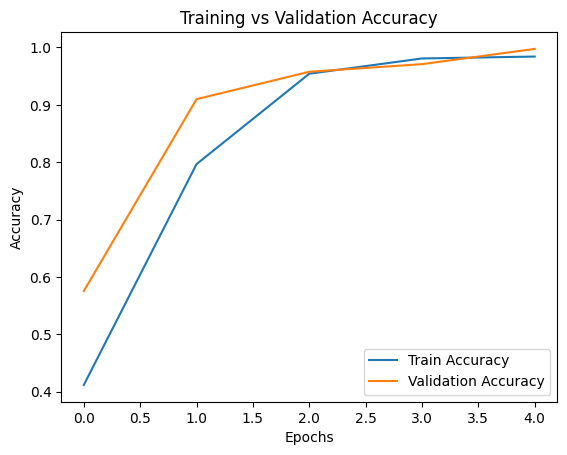

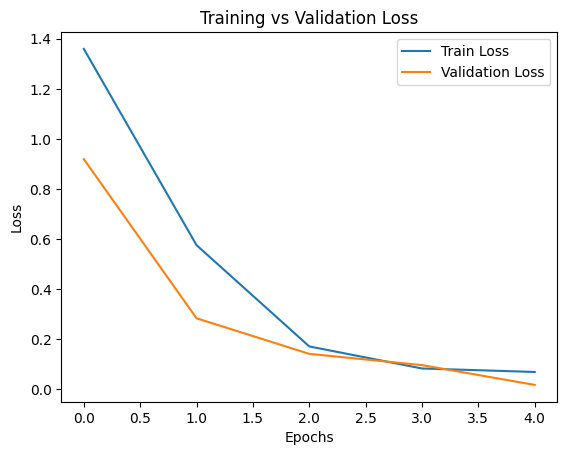

In [3]:
import matplotlib.pyplot as plt

# Plot akurasi latih dan uji
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Plot kerugian latih dan uji
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Precision
precision = precision_score(y_test, predicted_labels, average='weighted')
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_test, predicted_labels, average='weighted')
print(f"Recall: {recall}")

# F1-Score
f1 = f1_score(y_test, predicted_labels, average='weighted')
print(f"F1-Score: {f1}")


Precision: 0.9973742732363423
Recall: 0.9973474801061007
F1-Score: 0.9973458711325676


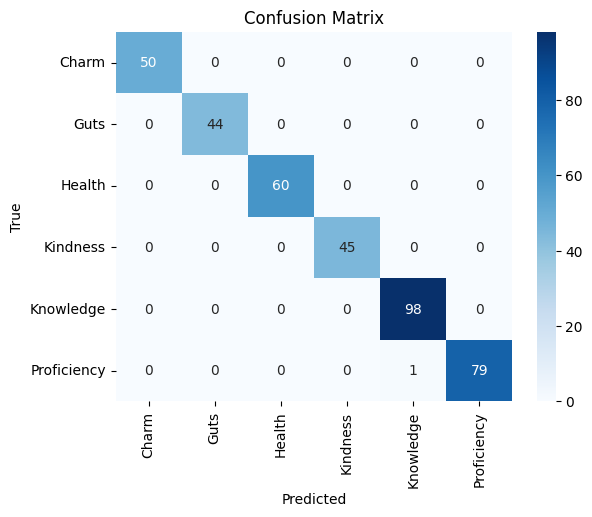

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predicted_labels)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [6]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_test, predicted_labels)
print(f"MCC: {mcc}")

MCC: 0.9967598909939362


In [ ]:
# Masukkan kalimat input yang ingin diuji
input_sentence = "Saya sudah belajar mengenai machine learning pagi ini"

# Tokenisasi kalimat input
input_encodings = tokenizer([input_sentence], truncation=True, padding=True, max_length=128)

# Konversi ke format TensorFlow Dataset (untuk input)
input_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": input_encodings["input_ids"],
        "attention_mask": input_encodings["attention_mask"]
    }
))

# Tambahkan batch size (karena model di-training dalam batch)
input_dataset = input_dataset.batch(1)

# Prediksi kelas dari model
predictions = model.predict(input_dataset)

# Dapatkan label kelas dengan probabilitas tertinggi
predicted_class = tf.argmax(predictions.logits, axis=1).numpy()[0]

# Dekode hasil prediksi ke nama label
predicted_label = label_encoder.inverse_transform([predicted_class])

# Tampilkan hasil prediksi
print(f"Kalimat: {input_sentence}")
print(f"Kategori Prediksi: {predicted_label[0]}")


1/1 [==============================] - 2s 2s/step
Kalimat: Saya sudah belajar mengenai machine learning pagi ini
Kategori Prediksi: Knowledge


# Dengan Tingkat Aktivitas

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

# Load dataset
guts_df = pd.read_csv("E:/Coding/persona-ai/datasets/guts_dataset.csv")
health_df = pd.read_csv("E:/Coding/persona-ai/datasets/health_dataset.csv")
kindness_df = pd.read_csv("E:/Coding/persona-ai/datasets/kindness_dataset.csv")
knowledge_df = pd.read_csv("E:/Coding/persona-ai/datasets/knowledge_dataset.csv")
proficiency_df = pd.read_csv("E:/Coding/persona-ai/datasets/proficiency_dataset.csv")
charm_df = pd.read_csv("E:/Coding/persona-ai/datasets/charm_dataset.csv")

C:\Users\Aim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Gabung semua dataset
all_data = pd.concat([
    guts_df, health_df, kindness_df,
    knowledge_df, proficiency_df, charm_df
], ignore_index=True)

assert "tingkat_aktivitas" in all_data.columns

all_data.tail()

,text_aktivitas,kategori,tingkat_aktivitas
1877,Saya berusaha untuk memberi perhatian lebih ke...,Charm,Berat
1878,Saya berbicara dengan nada suara yang menyenan...,Charm,Ringan
1879,Saya berusaha untuk mengerti perasaan orang la...,Charm,Berat
1880,Saya berusaha untuk mengerti perasaan orang la...,Charm,Ringan
1881,Saya mencoba untuk menjadi orang yang menyenan...,Charm,Ringan
